In [1]:
import pandas as pd
from math import log2
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
human_input = pd.read_csv('../data/human_input.no_empty_transcript.tsv', sep='\t', header=None)
human_input.columns = ['Gene ID', 'Transcript ID', 'GO list']

human_path = "../res/human.no_empty_transcript.intragene_isoform_diversity.data.tsv"
human_df = pd.read_csv(human_path, sep='\t')
human_df = human_df[human_df['Type'] == 'Observed']


rc_annotation = pd.read_csv('../data/introns_recountTagged.gencode.v45.primary_assembly.annotation.gtf', sep='\t', header=None, comment='#')

### Extracting recount

In [3]:
rc_annotation = rc_annotation.loc[:,[0,2,8]]
rc_annotation

,0,2,8
0,chr7,transcript,"gene_id ""ENSG00000293560.1""; transcript_id ""EN..."
1,chr7,intron,"gene_id ""ENSG00000293560.1""; transcript_id ""EN..."
2,chr7,intron,"gene_id ""ENSG00000293560.1""; transcript_id ""EN..."
3,chr7,intron,"gene_id ""ENSG00000293560.1""; transcript_id ""EN..."
4,chr7,intron,"gene_id ""ENSG00000293560.1""; transcript_id ""EN..."
...,...,...,...
1624741,chrX,intron,"gene_id ""ENSG00000000003.16""; transcript_id ""E..."
1624742,chrX,intron,"gene_id ""ENSG00000000003.16""; transcript_id ""E..."
1624743,chrX,intron,"gene_id ""ENSG00000000003.16""; transcript_id ""E..."
1624744,chrX,intron,"gene_id ""ENSG00000000003.16""; transcript_id ""E..."


In [4]:
transcript = rc_annotation[rc_annotation[2].isin(['transcript'])]
transcript

,0,2,8
0,chr7,transcript,"gene_id ""ENSG00000293560.1""; transcript_id ""EN..."
8,chr7,transcript,"gene_id ""ENSG00000293560.1""; transcript_id ""EN..."
10,chr7,transcript,"gene_id ""ENSG00000293559.1""; transcript_id ""EN..."
22,chr7,transcript,"gene_id ""ENSG00000293558.1""; transcript_id ""EN..."
26,chr7,transcript,"gene_id ""ENSG00000293557.1""; transcript_id ""EN..."
...,...,...,...
1624717,chrX,transcript,"gene_id ""ENSG00000000005.6""; transcript_id ""EN..."
1624720,chrX,transcript,"gene_id ""ENSG00000000005.6""; transcript_id ""EN..."
1624727,chrX,transcript,"gene_id ""ENSG00000000003.16""; transcript_id ""E..."
1624734,chrX,transcript,"gene_id ""ENSG00000000003.16""; transcript_id ""E..."


In [5]:
def makeinfodict(tags : str):
    tags = tags[:-1].split(';')
    infodict = dict()
    infodict['gene_id'] = tags[0].removesuffix('"').removeprefix('gene_id "')
    infodict['transcript_id'] = tags[1].removesuffix('"').removeprefix(' transcript_id "')
    if tags[-1] == ' recount_details ""':
        infodict['recount'] = 0
    else:
        infodict['recount'] = tags[6].removeprefix('Total_Reads=')
        infodict['transcript_type'] = tags[4].removeprefix(' transcript_type "').removesuffix('"')
    return infodict

In [6]:
only_coding_transcript = transcript[8].apply(lambda x: makeinfodict(x)['transcript_type']=='protein_coding')
transcript = transcript[only_coding_transcript]
transcript['ID'] = transcript[8].apply(lambda x : makeinfodict(x)['transcript_id'])
coding_transcript = transcript['ID'].tolist()
len(coding_transcript)

/tmp/ipykernel_23669/1929644496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript['ID'] = transcript[8].apply(lambda x : makeinfodict(x)['transcript_id'])


87641

In [7]:
collect_rc = dict()
with open('../data/introns_recountTagged.gencode.v45.primary_assembly.annotation.gtf') as gff:
    for entry in gff:
        entry = entry.strip().split('\t')
        if entry[2] == 'intron':
            info = makeinfodict(entry[-1])
            gID = info['gene_id']
            tID = info['transcript_id']
            rc = int(info['recount'])
            if gID not in collect_rc:
                collect_rc[gID] = dict()
            if tID not in collect_rc[gID]:
                collect_rc[gID][tID] = rc
            else:
                collect_rc[gID][tID] = min(rc, collect_rc[gID][tID])


In [8]:
recount_df = pd.DataFrame.from_records([(gID, tID, rc) for gID, midict in collect_rc.items() for tID, rc in midict.items()])
recount_df.columns = ['Gene ID', 'Transcript ID', 'Recount']

In [9]:
recount_df[recount_df['Transcript ID'].isin(coding_transcript)]

,Gene ID,Transcript ID,Recount
16,ENSG00000293552.1,ENST00000536108.6,930
27,ENSG00000293543.1,ENST00000713560.1,204362
28,ENSG00000293543.1,ENST00000707122.1,3423
31,ENSG00000293543.1,ENST00000372702.7,204362
33,ENSG00000293542.1,ENST00000713561.1,80347
...,...,...,...
226829,ENSG00000000419.14,ENST00000371588.10,17004778
226830,ENSG00000000419.14,ENST00000371584.9,623366
226831,ENSG00000000419.14,ENST00000371582.8,1423650
226833,ENSG00000000005.6,ENST00000373031.5,178053


### Entropy computation

In [10]:
human_input

,Gene ID,Transcript ID,GO list
0,ENSG00000292344,ENST00000711184.1,GO:0008081;GO:0006629;GO:0005737;GO:0042578;GO...
1,ENSG00000292344,ENST00000711182.1,GO:0008081;GO:0006629;GO:0042578;GO:0044238;GO...
2,ENSG00000292344,ENST00000711181.1,GO:0008081;GO:0006629;GO:0042578;GO:0044238;GO...
3,ENSG00000292344,ENST00000711176.1,GO:0008081;GO:0006629;GO:0042578;GO:0044238;GO...
4,ENSG00000292344,ENST00000711174.1,GO:0008081;GO:0006629;GO:0042578;GO:0044238;GO...
...,...,...,...
52270,ENSG00000079974,ENST00000354869.8,GO:0003924;GO:0006886;GO:0000242;GO:0005525;GO...
52271,ENSG00000079974,ENST00000395593.7,GO:0003924;GO:0006886;GO:0000242;GO:0005525;GO...
52272,ENSG00000079974,ENST00000690024.1,GO:0003924;GO:0005525;GO:0032561;GO:0019001;GO...
52273,ENSG00000079974,ENST00000685352.1,GO:0003924;GO:0005525;GO:0032561;GO:0019001;GO...


In [11]:
valid_transcript = human_input['Transcript ID'].tolist()

In [12]:
recount_df = recount_df[recount_df['Transcript ID'].isin(valid_transcript)]

In [13]:
def gene_entropy_1(raw):  # sum p*log(1/p)
    total = sum(raw)
    entropy = 0
    for val in raw:
        if val == 0:
            continue
        p = val/total
        ent = p*log2(1/p)
        entropy += ent
    return entropy

def gene_entropy_2(raw):  # sum p*log(p)
    total = sum(raw)
    entropy = 0
    for val in raw:
        if val == 0:
            continue
        p = val/total
        ent = p*log2(p)
        entropy += ent
    return entropy + log2(len(raw))

In [14]:
entropy1_df = recount_df.groupby('Gene ID').aggregate(gene_entropy_1).reset_index()
entropy1_df.columns = ['Gene', 'Entropy 1']
entropy1_df['Gene'] = entropy1_df['Gene'].apply(lambda x:x.split('.')[0])
entropy1_df
entropy2_df = recount_df.groupby('Gene ID').aggregate(gene_entropy_2).reset_index()
entropy2_df.columns = ['Gene', 'Entropy 2']
entropy2_df['Gene'] = entropy2_df['Gene'].apply(lambda x:x.split('.')[0])
entropy2_df

/tmp/ipykernel_23669/555447783.py:1: FutureWarning: ['Transcript ID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  entropy1_df = recount_df.groupby('Gene ID').aggregate(gene_entropy_1).reset_index()
/tmp/ipykernel_23669/555447783.py:5: FutureWarning: ['Transcript ID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  entropy2_df = recount_df.groupby('Gene ID').aggregate(gene_entropy_2).reset_index()


,Gene,Entropy 2
0,ENSG00000000005,0.000000
1,ENSG00000000419,1.402983
2,ENSG00000000457,0.909229
3,ENSG00000000460,0.055128
4,ENSG00000000938,0.075658
...,...,...
16774,ENSG00000292363,1.000000
16775,ENSG00000292366,1.000000
16776,ENSG00000292372,0.000000
16777,ENSG00000292373,0.000000


In [15]:
entropy_df = human_df.join(entropy1_df.set_index('Gene'), on='Gene', how='left')
entropy_df = entropy_df.join(entropy2_df.set_index('Gene'), on='Gene', how='left')
entropy_df['Entropy 2'].min()

0.0

[Text(0.5, 0, 'Number of isoform'), Text(0, 0.5, 'Entropy 1 (log)')]

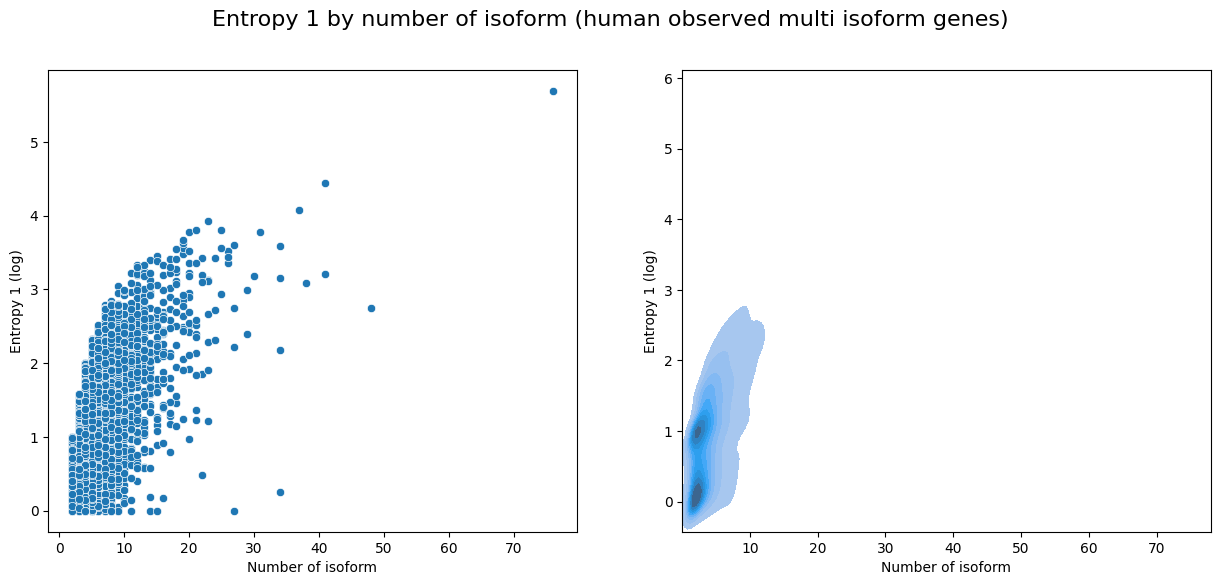

In [16]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Entropy 1 by number of isoform (human observed multi isoform genes)", fontsize=16)
plot = sns.scatterplot(
    data = entropy_df[entropy_df["Number of isoform"] > 1],
    x = 'Number of isoform',
    y = 'Entropy 1',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='Number of isoform', ylabel='Entropy 1 (log)')
plot = sns.kdeplot(
    data = entropy_df[entropy_df["Number of isoform"] > 1],
    x = 'Number of isoform',
    y = 'Entropy 1',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='Number of isoform', ylabel='Entropy 1 (log)')




[Text(0.5, 0, 'Number of isoform'), Text(0, 0.5, 'Entropy 2 (log)')]

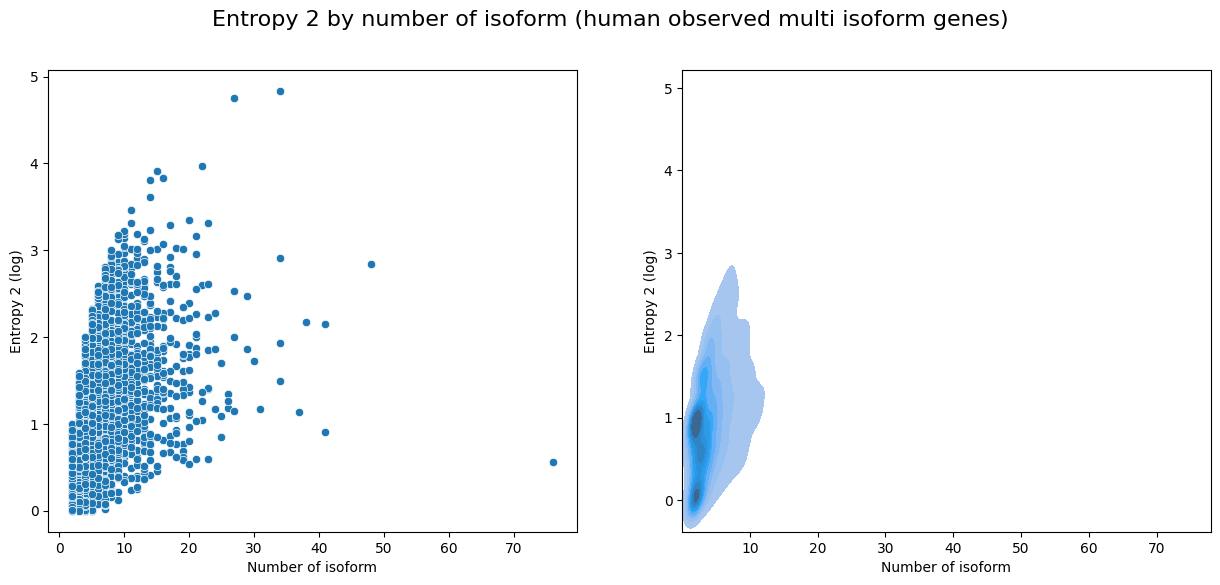

In [17]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Entropy 2 by number of isoform (human observed multi isoform genes)", fontsize=16)
plot = sns.scatterplot(
    data = entropy_df[entropy_df["Number of isoform"] > 1],
    x = 'Number of isoform',
    y = 'Entropy 2',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='Number of isoform', ylabel='Entropy 2 (log)')
plot = sns.kdeplot(
    data = entropy_df[entropy_df["Number of isoform"] > 1],
    x = 'Number of isoform',
    y = 'Entropy 2',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='Number of isoform', ylabel='Entropy 2 (log)')




[Text(0.5, 0, 'Jaccard Index'), Text(0, 0.5, 'Entropy 1 (log)')]

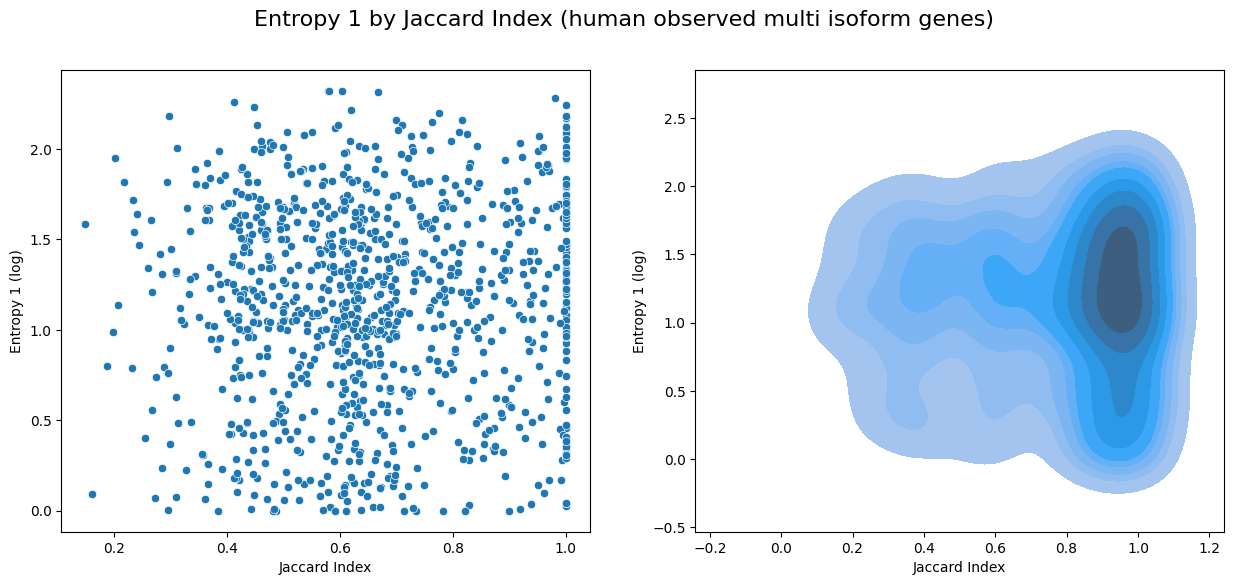

In [18]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Entropy 1 by Jaccard Index (human observed multi isoform genes)", fontsize=16)
plot = sns.scatterplot(
    data = entropy_df[entropy_df["Number of isoform"] ==5],
    x = 'Jaccard Index',
    y = 'Entropy 1',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='Jaccard Index', ylabel='Entropy 1 (log)')
plot = sns.kdeplot(
    data = entropy_df[entropy_df["Number of isoform"] ==5],
    x = 'Jaccard Index',
    y = 'Entropy 1',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='Jaccard Index', ylabel='Entropy 1 (log)')



[Text(0.5, 0, 'Jaccard Index'), Text(0, 0.5, 'Entropy 2 (log)')]

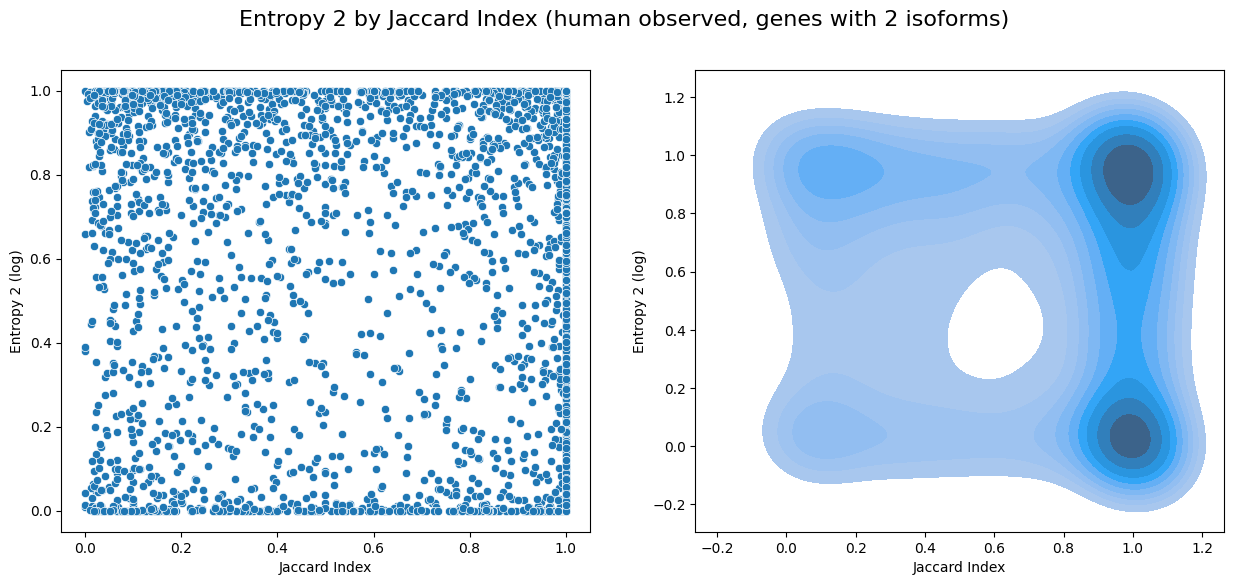

In [24]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Entropy 2 by Jaccard Index (human observed, genes with 2 isoforms)", fontsize=16)
plot = sns.scatterplot(
    data = entropy_df[entropy_df["Number of isoform"] ==2],
    x = 'Jaccard Index',
    y = 'Entropy 2',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='Jaccard Index', ylabel='Entropy 2 (log)')
plot = sns.kdeplot(
    data = entropy_df[entropy_df["Number of isoform"] ==2],
    x = 'Jaccard Index',
    y = 'Entropy 2',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='Jaccard Index', ylabel='Entropy 2 (log)')


[Text(0.5, 0, 'Jaccard Index'), Text(0, 0.5, 'Entropy 2 (log)')]

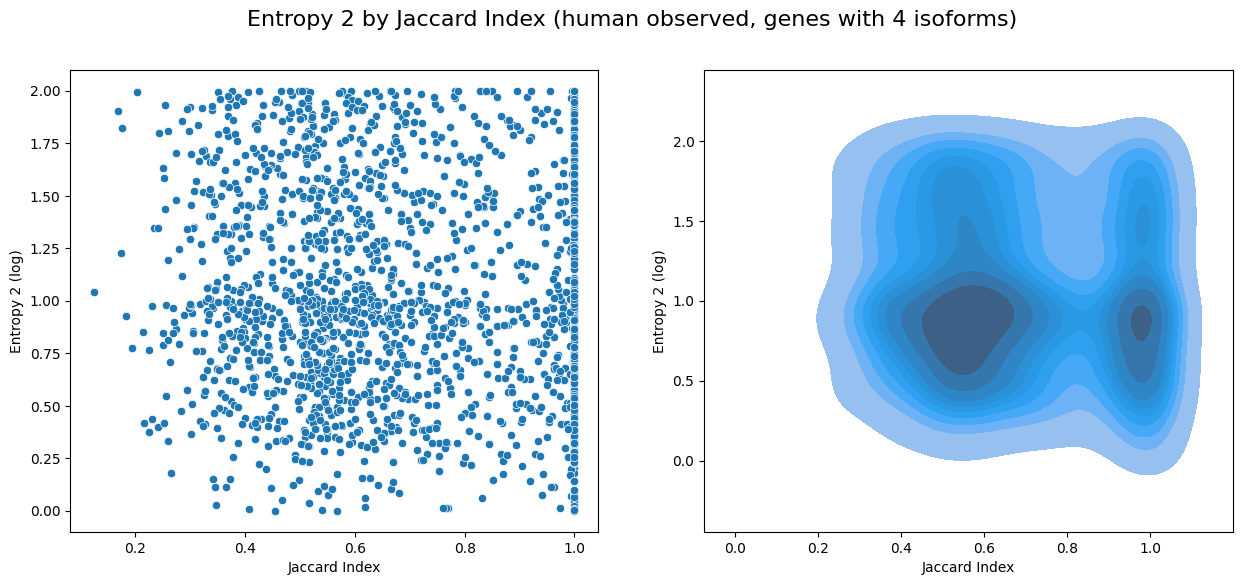

In [25]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Entropy 2 by Jaccard Index (human observed, genes with 4 isoforms)", fontsize=16)
plot = sns.scatterplot(
    data = entropy_df[entropy_df["Number of isoform"] ==4],
    x = 'Jaccard Index',
    y = 'Entropy 2',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='Jaccard Index', ylabel='Entropy 2 (log)')
plot = sns.kdeplot(
    data = entropy_df[entropy_df["Number of isoform"] ==4],
    x = 'Jaccard Index',
    y = 'Entropy 2',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='Jaccard Index', ylabel='Entropy 2 (log)')


[Text(0.5, 0, 'Jaccard Index'), Text(0, 0.5, 'Entropy 2 (log)')]

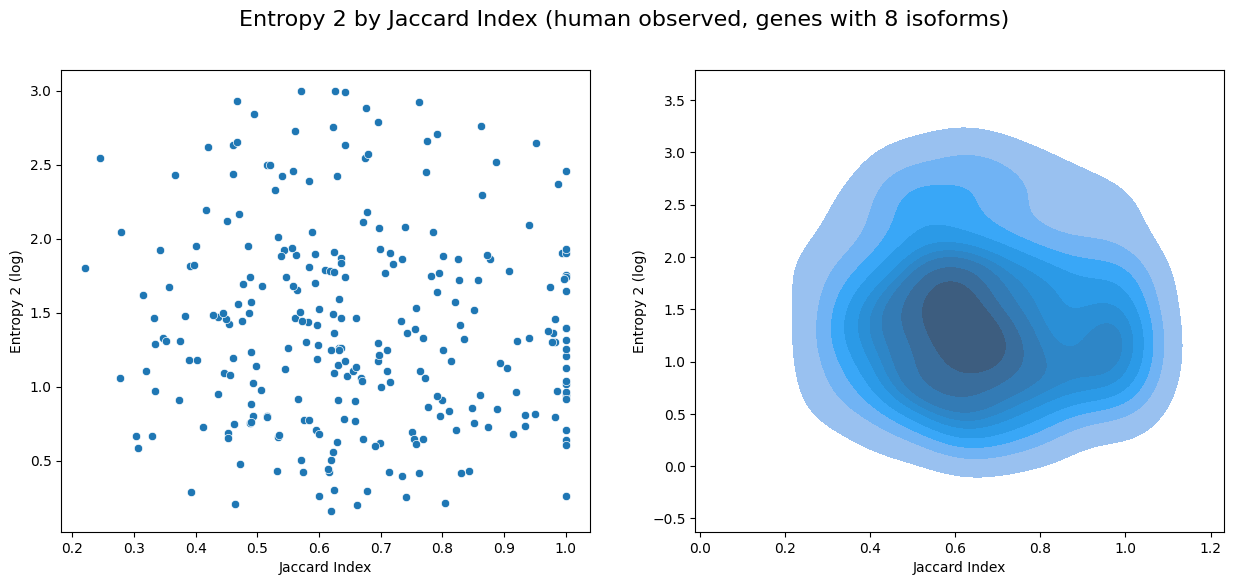

In [26]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Entropy 2 by Jaccard Index (human observed, genes with 8 isoforms)", fontsize=16)
plot = sns.scatterplot(
    data = entropy_df[entropy_df["Number of isoform"] ==8],
    x = 'Jaccard Index',
    y = 'Entropy 2',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='Jaccard Index', ylabel='Entropy 2 (log)')
plot = sns.kdeplot(
    data = entropy_df[entropy_df["Number of isoform"] ==8],
    x = 'Jaccard Index',
    y = 'Entropy 2',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='Jaccard Index', ylabel='Entropy 2 (log)')
